In [1]:
import numpy as np
import pandas as pd
import statsrat as sr
import nlopt
from statsrat import expr
from statsrat.expr.predef.kitten import lrn_pred
from statsrat.expr.predef.pvl_iti import extinction, renewal, reinstatement, blocking, latent_inhib, cs_score, cs2_score
import statsrat.exemplar as exemplar

In [2]:
#print(help(cs2_score))
print(cs_score.resp_pos)
print(cs2_score.resp_pos)
print(cs2_score.resp_neg)

['us', 'us']
['us', 'us']
None


In [3]:
# extinction with delay (in the home cage, i.e. a separate context) before test
extn_delay = expr.schedule(name = 'extinction_delay',
                        resp_type = 'exct',
                                   stage_list = [
                                       expr.stage(name = 'intro',
                                              x_pn = [[]],
                                              x_bg = ['ctx', 'time'],
                                              x_value = pd.Series({'ctx': 1.0, 'time': 0.0}),
                                              u_psb = ['us'],
                                              order_fixed = True,
                                              iti = 5,
                                              n_rep = 5),
                                       expr.stage(name = 'training',
                                             x_pn = [['cs']],
                                             x_bg = ['ctx', 'time'],
                                             x_value = pd.Series({'cs': 1.0, 'ctx': 1.0, 'time': 1.0}),
                                             u = [['us']],
                                             u_psb = ['us'],
                                             order_fixed = True, 
                                             iti = 5,
                                             n_rep = 5),
                                       expr.stage(name = 'extinction',
                                             x_pn = [['cs']],
                                             x_bg = ['ctx', 'time'],
                                             x_value = pd.Series({'cs': 1.0, 'ctx': 1.0, 'time': 2.0}),
                                             u_psb = ['us'],
                                             order_fixed = True,
                                             iti = 5,
                                             n_rep = 5),
                                       expr.stage(name = 'delay',
                                             x_pn = [[]],
                                             x_bg = ['home_cage', 'time'],
                                             x_value = pd.Series({'home_cage': 1.0, 'time': 3.0}),
                                             u_psb = ['us'],
                                             order_fixed = True,
                                             iti = 0,
                                             n_rep = 25),
                                       expr.stage(name = 'test',
                                             x_pn = [['cs']],
                                             x_bg = ['ctx', 'time'],
                                             x_value = pd.Series({'cs': 1.0, 'ctx': 1.0, 'time': 4.0}),
                                             u_psb = ['us'],
                                             order_fixed = True,
                                             iti = 5,
                                             n_rep = 5)
                                   ])

# delay (in the home cage, i.e. a separate context) before test
delay = expr.schedule(name = 'extinction_delay',
                      resp_type = 'exct',
                       stage_list = [
                           expr.stage(name = 'intro',
                                  x_pn = [[]],
                                  x_bg = ['ctx', 'time'],
                                  x_value = pd.Series({'ctx': 1.0, 'time': 0.0}),
                                  u_psb = ['us'],
                                  order_fixed = True,
                                  iti = 5,
                                  n_rep = 5),
                           expr.stage(name = 'training',
                                 x_pn = [['cs']],
                                 x_bg = ['ctx', 'time'],
                                 x_value = pd.Series({'cs': 1.0, 'ctx': 1.0, 'time': 1.0}),
                                 u = [['us']],
                                 u_psb = ['us'],
                                 order_fixed = True, 
                                 iti = 5,
                                 n_rep = 5),
                           expr.stage(name = 'delay',
                                 x_pn = [[]],
                                 x_bg = ['home_cage', 'time'],
                                 x_value = pd.Series({'home_cage': 1.0, 'time': 3.0}),
                                 u_psb = ['us'],
                                 order_fixed = True,
                                 iti = 0,
                                 n_rep = 25),
                           expr.stage(name = 'test',
                                 x_pn = [['cs']],
                                 x_bg = ['ctx', 'time'],
                                 x_value = pd.Series({'cs': 1.0, 'ctx': 1.0, 'time': 4.0}),
                                 u_psb = ['us'],
                                 order_fixed = True,
                                 iti = 5,
                                 n_rep = 5)
                       ])
foo = expr.experiment(schedules = {'extn_delay': extn_delay, 'delay': delay}, oats = None)
trials = foo.make_trials('extn_delay')

In [4]:
model = exemplar.model(name = 'basic',
                       sim = exemplar.sim.Gaussian,
                       atn_update = exemplar.atn_update.null,
                       lrate = exemplar.lrate.only_max)
                       #lrate = exemplar.lrate.from_sim) # This produces strange results, at least for Pavlovian conditioning.

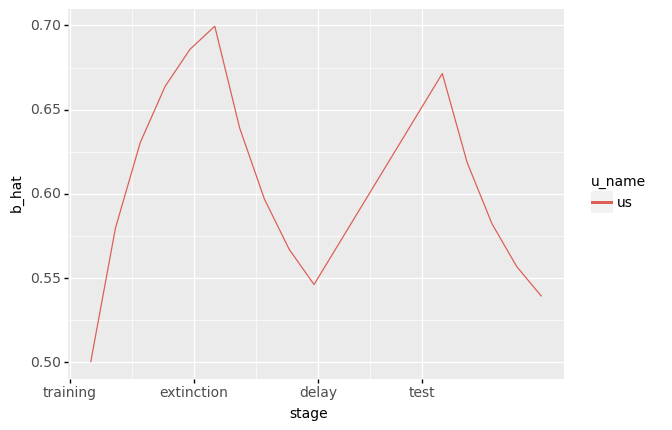

<ggplot: (296813159)>

In [5]:
init_atn = pd.DataFrame(1.0, index = trials.ex.index, columns = trials['x_name'].values)
init_atn['time'] = 0.01
init_atn.loc[['ctx.time2.0.cs', 'ctx.time2.0'], 'time'] = 1.0
#print(init_atn)
#print(help(sr.learn_plot))
ds = model.simulate(trials, init_atn = init_atn)
sr.learn_plot(ds, var = 'b_hat', only_main = True)
#sr.learn_plot(ds, var = 'u_hat', only_main = True)
#sr.learn_plot(ds, var = 'u_ex')

In [6]:
#max_time = 5
max_time = 30
algorithm = nlopt.GN_DIRECT_L
#algorithm = nlopt.GN_AGS
#algorithm = nlopt.GN_ORIG_DIRECT
#algorithm = nlopt.GD_STOGO

In [7]:
print('\n learned predictiveness')
oat_result = sr.perform_oat(model, lrn_pred, n = 1, max_time = max_time, algorithm = algorithm, minimize = False)
print(oat_result[0].round(3))
print(oat_result[1])


 learned predictiveness
Maximizing OAT score.
     decay_rate  lrate_par  value
max       2.904      0.581    0.0
  schedule      trial_name u_name  mean_resp
0   design  a.y -> nothing   cat3        0.5
1   design  a.y -> nothing   cat4        0.5
2   design  b.x -> nothing   cat3        0.5
3   design  b.x -> nothing   cat4        0.5


In [8]:
print('\n blocking')
oat_result = sr.perform_oat(model, blocking, n = 1, max_time = max_time, algorithm = algorithm, minimize = False)
print(oat_result[0].round(3))
print(oat_result[1])


 blocking
Maximizing OAT score.
     decay_rate  lrate_par  value
max       0.354      0.531  0.036
       schedule      trial_name u_name  mean_resp
0       control  cs2 -> nothing     us   0.506837
0  experimental  cs2 -> nothing     us   0.470540


In [9]:
print('\n latent inhibition')
oat_result = sr.perform_oat(model, latent_inhib, n = 1, max_time = max_time, algorithm = algorithm, minimize = False)
print(oat_result[0].round(3))
print(oat_result[1])


 latent inhibition
Maximizing OAT score.
     decay_rate  lrate_par  value
max       2.915      0.582    0.0
       schedule     trial_name u_name  mean_resp
0       control  cs -> nothing     us    0.53683
0  experimental  cs -> nothing     us    0.53683
